In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

In [35]:
# true metric
m_star = (-0.94,-0.34) #200 degree
m_star = (0.98,0.17) #11.47 degree

t_true = np.arccos(m_star[0])
if t_true > np.pi/2:
    t_true = np.pi*2-t_true

print(t_true)

def eta(x):
  return 1/(1+np.exp(5*x))

zeta = 0.5  # f_X /sim U(-1,1)

# implementation of proposition 1
def h_bar(t):
  m11, m00 = np.cos(t), np.sin(t)
  def hb(x):
    if m11+m00 >= 0:
      return int(eta(x)>=m00/(m11+m00))
    else:
      return int(eta(x)<=m00/(m11+m00))
  return hb

# calculate Confusion Matrix using fundamental rule for probability calculus
# def C11(h):  # P(Y=1, h=1)
#   def P11(x):
#     return eta(x)*h(x)*0.5
#   return integrate.quad(P11, -1, 1)[0]

# def C10(h):  # P(Y=0, h=1)
#   def P10(x):
#     return (1-eta(x))*h(x)*0.5
#   return integrate.quad(P10, -1, 1)[0]

# def C01(h):  # P(Y=1, h=0)
#   def P01(x):
#     return eta(x)*(1-h(x))*0.5
#   return integrate.quad(P01, -1, 1)[0]

# def C00(h):  # P(Y=0, h=0)
#   def P00(x):
#     return (1-eta(x))*(1-h(x))*0.5
#   return integrate.quad(P00, -1, 1)[0]

# def phi(t):
#   m11, m00 = np.cos(t), np.sin(t)
#   return m11*C11(h_bar(t))+m00*C00(h_bar(t))

# def phi2(m11, m00):
#   t = np.arccos(m11)
#   if t > np.pi/2:
#      t = np.pi*2-t
#   return m11*C11(h_bar(t))+m00*C00(h_bar(t))

# x_prime = np.log((m00+m11)/m00-1)/5
# analytical form ++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def C11(t):  # P(Y=1, h=1)
  m00,m11 = np.cos(t), np.sin(t)
  x_prime = 0.
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if str(x_prime) == 'nan':
    print((m00+m11)/m00-1)
  if m00+m11 >= 0:
    return 0.5*(x_prime-np.log(1+np.exp(x_prime))+1+np.log(1+np.exp(-1))) # x-ln(1+e^x)
  else:
    return 0.5*(1-np.log(1+np.exp(1))-x_prime+np.log(1+np.exp(x_prime)))

def C10(t):  # P(Y=0, h=1)
  return 0.5-C11(t)

def C01(t):  # P(Y=1, h=0)
  return 0.5-C00(t)

def C00(t):  # P(Y=0, h=0)
  m00,m11 = np.cos(t), np.sin(t)
  x_prime = 0
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return 0.5*(np.log(1+np.exp(1))-np.log(1+np.exp(x_prime)))  # ln(1+e^x)
  else:
    return 0.5*(np.log(1+np.exp(x_prime))-np.log(1+np.exp(-1)))

def phi(t, t_true):
  m11, m00 = np.cos(t), np.sin(t)
  return m11*C11(t_true)+m00*C00(t_true)

def phi2(m11, m00, t_true):
  return m11*C11(t_true)+m00*C00(t_true)

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# def query(t_1, t_2, alpha):
#   t = np.arccos(m_star[0])
#   if t > np.pi/2:
#     t = np.pi*2-t
#   if abs(t_1-t) > abs(t_2-t):
#     if np.random.rand() > alpha:
#       return 1  # prefer t2
#     else:
#       return 0
#   else:
#     if np.random.rand() > alpha:
#       return 0  # prefer t1
#     else:
#       return 1
    

def query(t_1, t_2, t_true, alpha):
  # if abs(phi(t_1)-phi2(m_star[0], m_star[1])) > abs(phi(t_2)-phi2(m_star[0], m_star[1])):
  if phi(t_1, t_true) < phi(t_2, t_true):
    return 1  # prefer t2
  else:
    return 0  # prefer t1

0.20033484232311968


In [ ]:
locals()

In [29]:
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def max_quasiconcave_metric(eps, alpha):
  t_a = 0
  t_b = np.pi*2
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    h_a = h_bar(t_a)
    h_b = h_bar(t_b)
    h_c = h_bar(t_c)
    h_d = h_bar(t_d)
    h_e = h_bar(t_e)
    C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    ca = query(t_c, t_a, t_true, alpha)
    dc = query(t_d, t_c, t_true, alpha)
    ed = query(t_e, t_d, t_true, alpha)
    be = query(t_b, t_e, t_true, alpha)
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

In [30]:
m,C = max_quasiconcave_metric(1e-4, 0.)
print("true metric: "+str(m_star))
print("elicited metric: "+str(m))
print("confusion matrix: \n"+str(C))

true metric: (0.98, 0.17)
elicited metric: [0.50444926 0.86344134]
confusion matrix: 
[[0.28246251 0.21753749]
 [0.16379162 0.33620838]]


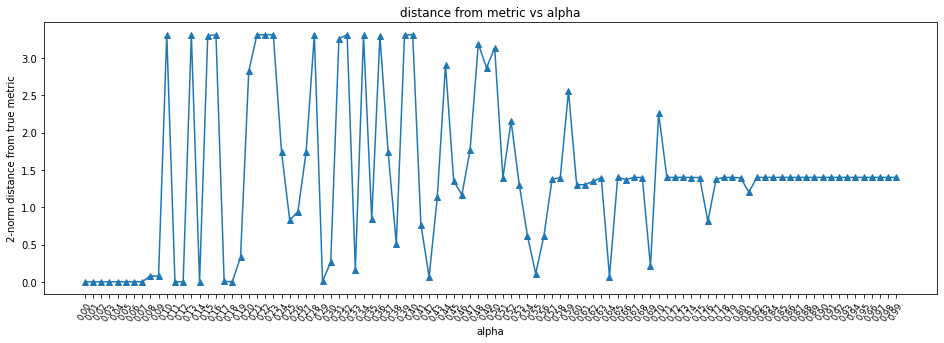

In [ ]:
re = []
step = 0.01
t_true = np.arccos(m_star[0])
if t_true > np.pi/2:
    t_true = np.pi*2-t_true
for al in np.arange(0., 1., step):
  m,C = max_quasiconcave_metric(1e-4, al)
  # re.append(abs(phi2(m[0], m[1])-phi2(m_star[0], m_star[1])))
  t = np.arccos(m[0])
  if t > np.pi/2:
    t = np.pi*2-t
  re.append(np.linalg.norm(t-t_true))

plt.figure(figsize=(16,5))
plt.plot(np.arange(0., 1., step), re, "^-")
# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.show()

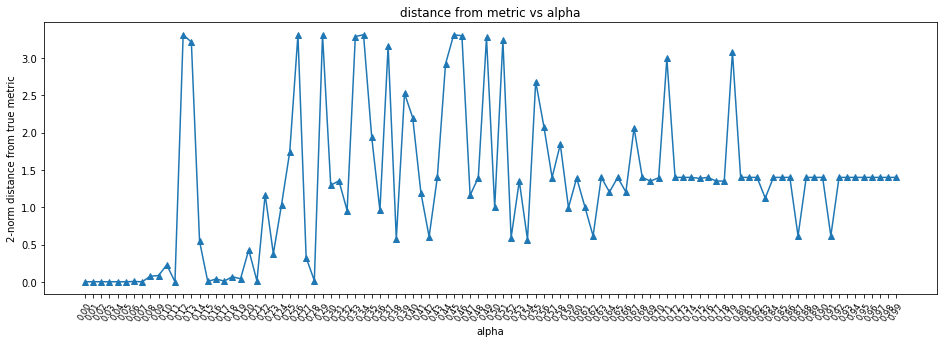

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(np.arange(0., 1., step), re, "^-")
# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.show()

In [ ]:
# implements algorithm 1
# alpha: error rate of oracle
def max_quasiconcave_metric(eps, alpha):
  t_a = 0
  t_b = np.pi*2
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    h_a = h_bar(t_a)
    h_b = h_bar(t_b)
    h_c = h_bar(t_c)
    h_d = h_bar(t_d)
    h_e = h_bar(t_e)
    C_a = np.array([[C00(h_a), C01(h_a)],[C10(h_a), C11(h_a)]])
    C_b = np.array([[C00(h_b), C01(h_b)],[C10(h_b), C11(h_b)]])
    C_c = np.array([[C00(h_c), C01(h_c)],[C10(h_c), C11(h_c)]])
    C_d = np.array([[C00(h_d), C01(h_d)],[C10(h_d), C11(h_d)]])
    C_e = np.array([[C00(h_e), C01(h_e)],[C10(h_e), C11(h_e)]])
    ca = query(t_c, t_a, alpha)
    dc = query(t_d, t_c, alpha)
    ed = query(t_e, t_d, alpha)
    be = query(t_b, t_e, alpha)
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

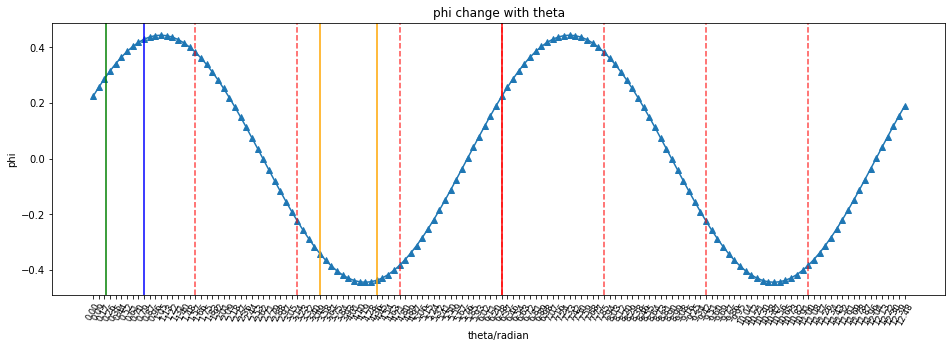

In [36]:
ph = []
for i in np.arange(0, np.pi*4, np.pi/36):
  ph.append(phi(i, t_true))

plt.figure(figsize=(16,5))
plt.plot(np.arange(0, np.pi*4, np.pi/36), ph, "^-")
for p in np.arange(0.5, 4, 0.5):
  plt.axvline(x=np.pi*p, c='r', ls='--', alpha=0.7)
plt.axvline(x=np.pi*2, c='r')
# plt.axvline(x=np.arccos(0.17), c='g')
plt.axvline(x=t_true, c='g')
plt.axvline(x=np.pi*2-np.arccos(-0.94), c='orange')
plt.axvline(x=np.pi*2-np.arccos(-0.34), c='orange')
plt.axvline(x=np.pi/4, c='b')
plt.xticks(np.arange(0, np.pi*4, np.pi/36), rotation=60, size="small")
plt.title("phi change with theta")
plt.xlabel("theta/radian")
plt.ylabel("phi")
plt.show()